In [34]:
import numpy as np
import matplotlib.pyplot as plt
#from __future__ import absolute_import, division, print_function


# TensorFlow and tf.keras

import pandas as pd


processed_data = np.load('Full_array.npy')
Blue_processed_data = np.load('Blue_Full_array.npy')
#The size of the dataset is 10,000; but I only filled the first 9166 with values, the rest are zeros. (shouldn't be counted)
number = 9166
processed_data = processed_data[0:number]

np.random.seed(1)


In [35]:
from PIL import Image
from cv2 import resize
from sklearn.utils import shuffle

In [36]:
import tensorflow as tf
from tensorflow import keras

In [37]:
#we want to normalize our iamge data to go from 0 to 1
#processed_data = processed_data.reshape(np.size(processed_data))
#processed_data = (processed_data - min(processed_data))/ (max(processed_data) - min(processed_data))
#processed_data = processed_data.reshape(number,28,28)
#I actually am not sure how it is scaled. however, some of the pixels are negative for some reason???

#also, this did not help.

#update, 5/11/19, I misunderstand the nature of my data. I am reading from fits files, and after having done some work reducing
#fits files in a course, I think I should look a little more closely at each of these files and see if i can normalize the data.
#My plan would be to make histograms of the entire data set, then find a region that is roughly where most of the data lies,
#then I will apply that filter to my FITS files, and divide by the range, which will ensure no negative numbers, and a proper range
#of 0 to 1. All numbers outside the range will be given the extrema value. 

#I would first implement this normalziaation on the next batch of Images that will be (10000,64,64,3), as I have also learned that I am terribly
#zoomed in on the centers of the galaxies, and my next batch of images will be out at a scale that captures the entire galaxy, and
#is also more close the GZ2 classification scale.

In [38]:
#hyperparameters:
test_train_split = 0.75
batch_size = 16
epoch_number = 50
learning_rate = 3e-6
validation_split = 0.10
dropout=0.40

#I have a non-round number of examples
train_split_indice = int(np.round(test_train_split*number))

In [39]:
#Load in my dataset of targets, targets are strings labels under the name "Class"
galaxyzoo = pd.read_csv("zoo2MainSpecz.csv/zoo2MainSpecz.csv", usecols=[2,3,4,8,15], nrows=number)
Class = galaxyzoo["gz2class"].values
RA = galaxyzoo['ra'].values
DEC = galaxyzoo['dec'].values

In [40]:
#I want to take the first character of the Class string and interpret as a integer, ala MNIST example code
dictionary = {'A':int(2),'E':int(1),'S':int(0)}

In [41]:
#resave using my dictionary
target = np.empty((len(Class)))
for i in range(len(Class)):
    target[i] = int(dictionary[Class[i][0]])

In [43]:
#split my data between training and test sets
train_target = target[0:train_split_indice]
test_target = target[train_split_indice:number]
train_images = processed_data[0:train_split_indice]
test_images = processed_data[train_split_indice:number]
Blue_train_images = Blue_processed_data[0:train_split_indice]
Blue_test_images = Blue_processed_data[train_split_indice::]

In [44]:
#Create 3 more images from each of my training and testing images that is each image but flipped 90 degrees...

#the below are commented out because I found that augmentation did not significantly improve the NN in this instance. But
#in summary, I first flip each image 90 degrees 3 times, and append that to my data array. Then I randomly rotate the entire data
#array by -45 to 45 degrees, and also zoom in or out from 0.7 to 1.3. I do these things at an attempt of data augmentation as I 
#had seen suggested online in forums and blog posts. Because of the cosmological principle, I should of course be robust to these
#rotations anyways.
"""
train_images_flip1 = np.flip(train_images,1)
train_images_flip2 = np.flip(train_images,2)
train_images_flip3 = np.flip(train_images_flip1,2)

flipped_img = np.append(train_images, train_images_flip1, 0)
flipped_img = np.append(flipped_img, train_images_flip2, 0)
flipped_img = np.append(flipped_img, train_images_flip3, 0)

flipped_tar = np.append(train_target,train_target, 0)
flipped_tar = np.append(flipped_tar,train_target, 0)
flipped_tar = np.append(flipped_tar,train_target, 0)

print(np.shape(flipped_tar))
print(np.shape(flipped_img))
print(np.size(train_target)*4)

print(np.shape(test_target))

#train_images = flipped_img
#train_target = flipped_tar
"""

'\ntrain_images_flip1 = np.flip(train_images,1)\ntrain_images_flip2 = np.flip(train_images,2)\ntrain_images_flip3 = np.flip(train_images_flip1,2)\n\nflipped_img = np.append(train_images, train_images_flip1, 0)\nflipped_img = np.append(flipped_img, train_images_flip2, 0)\nflipped_img = np.append(flipped_img, train_images_flip3, 0)\n\nflipped_tar = np.append(train_target,train_target, 0)\nflipped_tar = np.append(flipped_tar,train_target, 0)\nflipped_tar = np.append(flipped_tar,train_target, 0)\n\nprint(np.shape(flipped_tar))\nprint(np.shape(flipped_img))\nprint(np.size(train_target)*4)\n\nprint(np.shape(test_target))\n'

In [47]:
"""
#rotate each image in the target_images by a random amount
rotations_array = np.empty((31164,28,28))
for i in range(np.shape(train_images)[0]):
    degree = np.random.uniform(-45,45,1)
    img = Image.fromarray(train_images[i])
    rot = img.rotate(degree)
    rot = np.asarray(rot)
    rotations_array[i] = rot
#now append rotations_array to train_images
train_images = np.append(train_images, rotations_array,0)
#now append the class labels to the train_target array
train_target = np.append(train_target,train_target)


#every time we run this segment, we increase our training set by a factor of 2. this means it will train in 120 * number of times
# times 20 epochs = a long time.
"""

'\n#rotate each image in the target_images by a random amount\nrotations_array = np.empty((31164,28,28))\nfor i in range(np.shape(train_images)[0]):\n    degree = np.random.uniform(-45,45,1)\n    img = Image.fromarray(train_images[i])\n    rot = img.rotate(degree)\n    rot = np.asarray(rot)\n    rotations_array[i] = rot\n#now append rotations_array to train_images\ntrain_images = np.append(train_images, rotations_array,0)\n#now append the class labels to the train_target array\ntrain_target = np.append(train_target,train_target)\n\n\n#every time we run this segment, we increase our training set by a factor of 2. this means it will train in 120 * number of times\n# times 20 epochs = a long time.\n'

In [48]:
"""
def cv2_clipped_zoom(img, zoom_factor):
    
    ##Center zoom in/out of the given image and returning an enlarged/shrinked view of 
    ##the image without changing dimensions
    ##Args:
    ##    img : Image array
    ##    zoom_factor : amount of zoom as a ratio (0 to Inf)
    
    height, width = img.shape[:2] # It's also the final desired shape
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)

    ### Crop only the part that will remain in the result (more efficient)
    # Centered bbox of the final desired size in resized (larger/smaller) image coordinates
    y1, x1 = max(0, new_height - height) // 2, max(0, new_width - width) // 2
    y2, x2 = y1 + height, x1 + width
    bbox = np.array([y1,x1,y2,x2])
    # Map back to original image coordinates
    bbox = (bbox / zoom_factor).astype(np.int)
    y1, x1, y2, x2 = bbox
    cropped_img = img[y1:y2, x1:x2]

    # Handle padding when downscaling
    resize_height, resize_width = min(new_height, height), min(new_width, width)
    pad_height1, pad_width1 = (height - resize_height) // 2, (width - resize_width) //2
    pad_height2, pad_width2 = (height - resize_height) - pad_height1, (width - resize_width) - pad_width1
    pad_spec = [(pad_height1, pad_height2), (pad_width1, pad_width2)] + [(0,0)] * (img.ndim - 2)

    result = resize(cropped_img, (resize_width, resize_height))
    result = np.pad(result, pad_spec, mode='constant')
    assert result.shape[0] == height and result.shape[1] == width
    return result
"""

In [49]:
"""
#increase by a factor of two again, like above
rotations_array = np.empty((31164*2,28,28))
for i in range(np.shape(train_images)[0]):
    degree = np.random.uniform(-45,45,1)
    img = Image.fromarray(train_images[i])
    rot = img.rotate(degree)
    zoom_factor = np.random.uniform(0.7,1.3,1)
    rot = cv2_clipped_zoom(np.asarray(rot),zoom_factor)
    #rot = rot.resize()
    #rot = np.asarray(rot)
    rotations_array[i] = rot
#now append rotations_array to train_images
train_images = np.append(train_images, rotations_array,0)
#now append the class labels to the train_target array
train_target = np.append(train_target,train_target)
"""

'\n#increase by a factor of two again, like above\nrotations_array = np.empty((31164*2,28,28))\nfor i in range(np.shape(train_images)[0]):\n    degree = np.random.uniform(-45,45,1)\n    img = Image.fromarray(train_images[i])\n    rot = img.rotate(degree)\n    zoom_factor = np.random.uniform(0.7,1.3,1)\n    rot = cv2_clipped_zoom(np.asarray(rot),zoom_factor)\n    #rot = rot.resize()\n    #rot = np.asarray(rot)\n    rotations_array[i] = rot\n#now append rotations_array to train_images\ntrain_images = np.append(train_images, rotations_array,0)\n#now append the class labels to the train_target array\ntrain_target = np.append(train_target,train_target)\n'

In [50]:
#resizes images to be 32x32 using cv2. my choice of model requires 32x32x3 images. I will have to add in the other channels as 
#copies

import cv2 as cv2
train_images_resized = np.empty((np.shape(train_images)[0],32,32))
test_images_resized = np.empty((np.shape(test_images)[0],32,32))
for i in range(np.shape(train_images)[0]):
#img = cv2.imread(train_images[0])
    train_images_resized[i] = resize(train_images[i], dsize=(32,32))
for j in range(np.shape(test_images)[0]):
    test_images_resized[j] = resize(test_images[j], dsize=(32,32))

test_images = test_images_resized
train_images = train_images_resized

In [51]:
#Do the same for the Blue_train_images and Blue_test_images
train_images_resized = np.empty((np.shape(train_images)[0],32,32))
test_images_resized = np.empty((np.shape(test_images)[0],32,32))
for i in range(np.shape(Blue_train_images)[0]):
#img = cv2.imread(train_images[0])
    train_images_resized[i] = resize(Blue_train_images[i], dsize=(32,32))
for j in range(np.shape(test_images)[0]):
    test_images_resized[j] = resize(Blue_test_images[j], dsize=(32,32))

Blue_test_images = test_images_resized
Blue_train_images = train_images_resized

In [52]:
#reform into the tensor shape
train_images_number = np.shape(train_images)[0]
test_images_number = np.shape(test_images)[0]
train_images = train_images.reshape(train_images_number,32,32,1)
test_images = test_images.reshape(test_images_number,32,32,1)
Blue_train_images = Blue_train_images.reshape(train_images_number,32,32,1)
Blue_test_images = Blue_test_images.reshape(test_images_number,32,32,1)

In [53]:
#shuffle the order of the augmented images randomly, shuffle the order of the targets the same way.
#train_images, train_target = shuffle(train_images, train_target, random_state=1)

In [54]:
#Now I will add the arrays together to get (32,32,3) images, with green, green, blue filters from SDSS. I do this because the NN
#I chose (somewhat randomly) to try transfer learning with requires atleast (32,32,3), and at this point I don't have red images.

#I also did not want to go through the hassle of querying SkyView for original (32,32) images, since the only way I knew how was 
#very slow and often needed my attention to keep the process going.

train_images_middle_step = np.append(train_images, train_images, 3)
train_images = np.append(train_images_middle_step, Blue_train_images, 3)

test_images_middle_step = np.append(test_images,test_images, 3)
test_images = np.append(test_images_middle_step,Blue_test_images, 3)

#consider saving this array in the future instead of wasting time re-running the damn thing.

(6874, 32, 32, 1)
(2292, 32, 32, 3)
(6874, 32, 32, 3)


In [55]:
#load in and define my model, using transfer learning from a NN that was trained on image net
#https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e

#I chose vgg16 somewhat randomly, but I knew I wanted something that had few layers to begin with because I only have access to my
#laptop, so I can't afford huge networks with tons of parameters in memory; and now reflecting on this perhaps I have confused
#layers with trainable parameters as the thing that costs memory... 

from tensorflow.keras.applications import vgg16
from tensorflow.keras import layers
Input_layer = layers.Input(shape=(32,32,3))
base_model = vgg16.VGG16(include_top=False, weights='imagenet',input_tensor=Input_layer)

x=base_model.output
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dropout(dropout)(x)
x=layers.Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.

#commented out the below because my previous attempt had a structure 1024 -> 3 dense layer. Kept it commented because I might
#go back and re-add the layers here, and this will serve as a reminder to do that.

#x=layers.Dense(512,activation='relu')(x) #dense layer 2
#x=layers.Dense(128,activation='relu')(x) #dense layer 3
preds=layers.Dense(3,activation='softmax')(x) #final layer with softmax activation

In [56]:
#define our model using the loaded base_model and our added layers
from tensorflow.keras import Model
model=Model(inputs=base_model.input,outputs=preds)

In [57]:
#now that we have a model, we want to check the number of layers
for i,layer in enumerate(model.layers):
    print(i,layer.name)

0 input_2
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_average_pooling2d_1
20 dropout_1
21 dense_2
22 dense_3


In [58]:
#using the number of layers, we want to then tell the classifier to only train the new top layers, the dense layers we added
#so that we maximize the benefit of the imagenet training.

#for layer in model.layers:
#    layer.trainable=False

# or if we want to set the first 19 layers of the network to be non-trainable
for layer in model.layers[:15]:
    layer.trainable=False
for layer in model.layers[15:]:
    layer.trainable=True

In [61]:
#define an optimizer, loss, and accuracy metric.
adam = tf.keras.optimizers.Adam(learning_rate = learning_rate)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [62]:
#If I were to make all of the augmentations, I probably ought to use one of these guys. Just keeping it as a note to future self

"""
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=40,
    zoom_range=0.3,
    fill_mode='nearest'
    horizontal_flip=True,
    vetical_flip=True,
    data_format='channels_last',
    validation_split=validation_split)

datagen.fit(train_images)

model.fit_generator(datagen.flow(train_images, train_targets, batch_size=batch_size),
                    steps_per_epoch=len(x_train) / batch_size, epochs=epoch_number)
"""

"\ndatagen = ImageDataGenerator(\n    featurewise_center=True,\n    featurewise_std_normalization=True,\n    rotation_range=40,\n    zoom_range=0.3,\n    fill_mode='nearest'\n    horizontal_flip=True,\n    vetical_flip=True,\n    data_format='channels_last',\n    validation_split=validation_split)\n\ndatagen.fit(train_images)\n\nmodel.fit_generator(datagen.flow(train_images, train_targets, batch_size=batch_size),\n                    steps_per_epoch=len(x_train) / batch_size, epochs=epoch_number)\n"

In [63]:
#train, then print validation scores
history = model.fit(train_images, train_target, validation_split=validation_split, epochs=epoch_number, batch_size=batch_size, verbose=1, shuffle=True)

Train on 6186 samples, validate on 688 samples
Epoch 1/50
6186/6186 [==============================] - 289s 47ms/sample - loss: 0.9600 - accuracy: 0.5057 - val_loss: 0.7932 - val_accuracy: 0.6265
Epoch 2/50
6186/6186 [==============================] - 287s 46ms/sample - loss: 0.8228 - accuracy: 0.5786 - val_loss: 0.7363 - val_accuracy: 0.6962
Epoch 3/50
6186/6186 [==============================] - 292s 47ms/sample - loss: 0.7620 - accuracy: 0.6361 - val_loss: 0.7126 - val_accuracy: 0.6977
Epoch 4/50
6186/6186 [==============================] - 289s 47ms/sample - loss: 0.7272 - accuracy: 0.6437 - val_loss: 0.6997 - val_accuracy: 0.6962
Epoch 5/50
6186/6186 [==============================] - 289s 47ms/sample - loss: 0.6972 - accuracy: 0.6675 - val_loss: 0.6925 - val_accuracy: 0.6977
Epoch 6/50
6186/6186 [==============================] - 289s 47ms/sample - loss: 0.6773 - accuracy: 0.6796 - val_loss: 0.6868 - val_accuracy: 0.7020
Epoch 7/50
6186/6186 [==============================] - 286

In [64]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


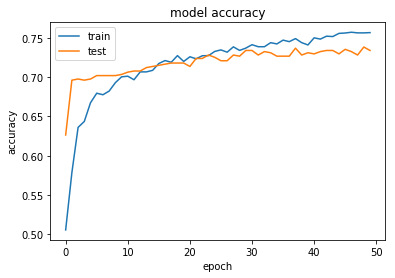

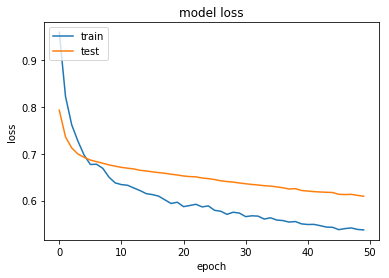

In [65]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#analysis: It seem I may need to decrease my LR after epoch 30? I do not seem to be over training, but maybe am running into
#rocky area around epoch 30 where I am overshooting the convergence. Doesn't seem to be a smooth decrease after epoch 30?

#I am altogether unsure of how to interpret. or how to change LR on the fly for that matter...

#I am also worried about the fact that I do not have R and B data, because I know a big feature should be blue light vs red light

#Note, this was also done without any data augmentation.

#note, 0.905^30 = 0.05; 0.93^30 = 0.1; actually seems more likely that epoch=12 is where we start to come apart
#so note, 0.83^12 = 0.1, 0.7^12 = 0.01
#might consider that we should decay the learning rate so that we decrease is by a signicant amount by this epoch so that we
#avoid the bumpy bit and keep moving smoothly??

In [66]:
#model.summary()
test_loss, test_acc = model.evaluate(test_images, test_target)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)
#0.82 with LR = 3e-5, batch size=64, epochs=20, dropout=0.40.

#0.82 with LR 3e-4, batch size=64, epochs=10, dropout=0.4.

#LR 3e-3 caused no training, random guesses

#LR 5e-4 slightly too high, didn't train as well as 3e-4 

#last attempt on this notebook:
#LR = 3e-4, 50 epochs, 64 batch size, dropout=0.4; test accuracy=0.8032

2292/2292 [==============================] - 18s 8ms/sample - loss: 0.6237 - accuracy: 0.7243
Test accuracy: 0.7242583
Test loss: 0.6237458839466434


<b>Update 5/11/19</b> Below are the graphs from one of the outputs from the transfer learning attempts I did. I did not use augmentation on this run, because in previous attempts I noticed that networks took much much longer to train and I felt that the network was not being as successful as my previous CNN without transfer attempts. This is an attempt with a blue channel.

interpreting these graphs I would say that the LR is right and that my network is working correctly. I think these graphs are about what a professional netowork might look like, but the problem is that I wanted more accuracy. The number I had as a target is 90%. So, I moved on. 

Reflecting on it, It would appear that I could still squeeze a bit more accuracy out of this NN with more epochs. One reason I am hesitant to run that experiment is that all of this is done from my personal laptop, when I run this transfer learning code it slows down everything else, which is undesirable when trying to complete my actual coursework. Now that it is summer, I might change my tune.

<img src='Transfer_Learning_epochs_50_acc.png'>

<img src='Transfer_Learning_epochs_50_loss.png'>